In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, countmap
using Statistics

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, run_simple!, Strategy, C, C_rate

include("../src/Network.jl")
using .Network: mat_degree

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="Times New Roman",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
);

In [3]:
function moving_average(data::Vector{Float64}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

function calc_cross_cor(x::Vector{Float64}, y::Vector{Float64}, lag_vec::StepRange{Int64, Int64})::Vector{Float64}
    l = min(length(x), length(y))
    max_lag = maximum(lag_vec)

    if l <= max_lag
        @show x
        @show y
        return [0.0]
    end

    _x = x[(end - l + 1):end]
    _y = y[(end - l + 1):end]
    return [cor(_x[(max_lag+1):(end-max_lag)], _y[(max_lag+1+lag):(end-max_lag+lag)]) for lag in lag_vec]
end;

In [4]:
trials = 100
peak_node_variability_vec = 0:1:49

C_rate_vec_vec_vec = []

for peak_node_variability in peak_node_variability_vec
    @show peak_node_variability
    p = Param(
        N = 100,
        k₀ = 4,
        generations = 10_000,
        C_rate₀ = 0.0,
        relationship_increment_factor = 1.0,
        resource_decrement_factor = 0.02,
        resource_limit_μ = 0.5,
        b = 1.8,
        peak_node_variability = peak_node_variability,
        resource_limit_β = 0.0,
        resource_limit_σ = 0.0,
    )

    C_rate_vec_vec = []

    for _ in 1:trials
        random_seed = rand(1:typemax(Int16))
        m = Model(p, MersenneTwister(random_seed))
        C_rate_vec = run_simple!(m, MersenneTwister(random_seed))
        push!(C_rate_vec_vec, C_rate_vec)
    end

    push!(C_rate_vec_vec_vec, C_rate_vec_vec)
end;

peak_node_variability = 0
peak_node_variability = 1
peak_node_variability = 2
peak_node_variability = 3
peak_node_variability = 4
peak_node_variability = 5
peak_node_variability = 6
peak_node_variability = 7
peak_node_variability = 8
peak_node_variability = 9
peak_node_variability = 10
peak_node_variability = 11
peak_node_variability = 12
peak_node_variability = 13
peak_node_variability = 14
peak_node_variability = 15
peak_node_variability = 16
peak_node_variability = 17
peak_node_variability = 18
peak_node_variability = 19
peak_node_variability = 20
peak_node_variability = 21
peak_node_variability = 22
peak_node_variability = 23
peak_node_variability = 24
peak_node_variability = 25
peak_node_variability = 26
peak_node_variability = 27
peak_node_variability = 28
peak_node_variability = 29
peak_node_variability = 30
peak_node_variability = 31
peak_node_variability = 32
peak_node_variability = 33
peak_node_variability = 34
peak_node_variability = 35
peak_node_variability = 36
peak_node_v

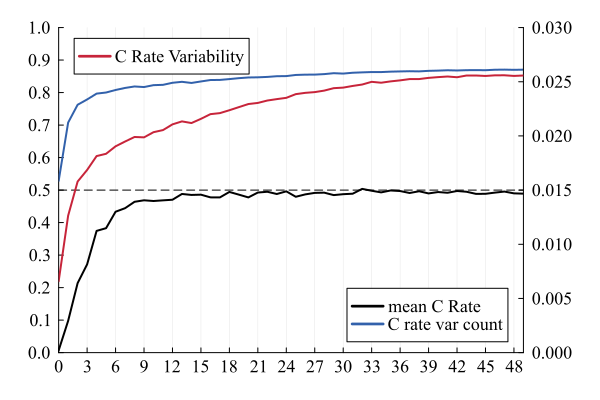

In [5]:
mean_C_rate_vec = []
std_C_rate_vec = []
mean_C_rate_var_vec = []
C_rate_var_count_vec = []

for (i, peak_node_variability) in enumerate(peak_node_variability_vec)
    C_rate_vec_vec = C_rate_vec_vec_vec[i]

    mean_C_rate = mean([mean(C_rate_vec) for C_rate_vec in C_rate_vec_vec])
    std_C_rate = mean([std(C_rate_vec) for C_rate_vec in C_rate_vec_vec])
    mean_C_rate_var = mean([mean(abs.(C_rate_vec[2:end] .- C_rate_vec[1:(end-1)])) for C_rate_vec in C_rate_vec_vec])
    C_rate_var_count = mean([mean(abs.(C_rate_vec[2:end] .- C_rate_vec[1:(end-1)]) .> 0) for C_rate_vec in C_rate_vec_vec])

    push!(mean_C_rate_vec, mean_C_rate)
    push!(std_C_rate_vec, std_C_rate)
    push!(mean_C_rate_var_vec, mean_C_rate_var)
    push!(C_rate_var_count_vec, C_rate_var_count)
end

plot(peak_node_variability_vec, fill(0.5, length(peak_node_variability_vec)), xlim=(0, maximum(peak_node_variability_vec)), xticks=0:3:51, ylim=(0, 1), yticks=0:0.1:1, lw=1, ls=:dash, lc=CS.BLACK, label=false)
plot!(peak_node_variability_vec, mean_C_rate_vec, lw=2, lc=CS.BLACK, label="mean C Rate")
plot!(peak_node_variability_vec, C_rate_var_count_vec, lw=2, lc=CS.BLUE, label="C rate var count")
# plot!(peak_node_variability_vec, std_C_rate_vec, lw=2, lc=CS.BLUE, label="std C Rate")
plot!(twinx(), peak_node_variability_vec, mean_C_rate_var_vec, lw=2, lc=CS.RED, label="C Rate Variability", xlim=(0, maximum(peak_node_variability_vec)), ylim=(0, 0.03), yticks=0:0.005:1)

In [6]:
time_lag_vec = -100:1:100
cross_cor_env_var_C_rate_vec_vec = []
cross_cor_env_var_C_rate_var_vec_vec = []

for i in 1:trials
    model_vec = model_vec_vec[i]
    
    # Variables
    C_rate_vec = [C_rate(m) for m in model_vec]
    # C_rate_var_vec = abs.(C_rate_vec[2:end] .- C_rate_vec[1:(end-1)])
    # C_rate_var_vec = (C_rate_vec[2:end] .- C_rate_vec[1:(end-1)])
    # C_rate_var_vec = Float64.((C_rate_vec[2:end] .- C_rate_vec[1:(end-1)]).> 0)
    C_rate_var_vec = abs.(C_rate_var_vec_vec[i])
    degree_SD_vec = [std(mat_degree(m.relation_mat)) for m in model_vec]
    prime_node_vec = [m.peak_node for m in model_vec]
    env_var_vec = Float64.(abs.(prime_node_vec[2:end] .- prime_node_vec[1:(end-1)]))
    env_var_vec = [x > 50 ? 100 - x : x for x in env_var_vec]
    env_var_vec = Float64.(env_var_vec .> 8)
    # @show env_var_vec

    # Moving average
    window_size = 1
    moving_C_rate_vec = moving_average(C_rate_vec, window_size)
    moving_C_rate_var_vec = moving_average(C_rate_var_vec, window_size)
    moving_env_var_vec = moving_average(env_var_vec, window_size)

    # Cross-correlation
    push!(cross_cor_env_var_C_rate_vec_vec, calc_cross_cor(moving_env_var_vec, moving_C_rate_vec, time_lag_vec))
    push!(cross_cor_env_var_C_rate_var_vec_vec, calc_cross_cor(moving_env_var_vec, moving_C_rate_var_vec, time_lag_vec))
end;

LoadError: UndefVarError: `model_vec_vec` not defined

In [7]:
mean_env_var_C_rate_vec = [mean([cross_cor_env_var_C_rate_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_env_var_C_rate_vec = [std([cross_cor_env_var_C_rate_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
mean_env_var_C_rate_var_vec = [mean([cross_cor_env_var_C_rate_var_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
std_env_var_C_rate_var_vec = [std([cross_cor_env_var_C_rate_var_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]

# Plot base
plt = plot(
    xticks=minimum(time_lag_vec):10:maximum(time_lag_vec),
    xlabel="Lag",
    # ylim=(-0.1, 0.1),
    yticks=-1:0.1:1,
    ylabel="Correlation Coefficient",
    title="Cross-Correlation Analysis (b = $(p.b), \\sigma_{R} = $(p.peak_node_variability))",
    legend=:right,
)

function plot_cross_correlation!(plt::Plots.Plot, time_lag_vec::AbstractVector, mean_vec::Vector{Float64}, std_vec::Vector{Float64}, label::String, color::String)::Nothing
    plot!(
        plt,
        time_lag_vec,
        mean_vec,
        label=label,
        lc=color,
        lw=2,
        # ribbon=std_vec,
        # fillcolor=color,
    )
    
    return
end

# Plot cross-correlation
plot_cross_correlation!(plt, time_lag_vec, mean_env_var_C_rate_vec, std_env_var_C_rate_vec, "(env var, C rate)", CS.RED)
plot_cross_correlation!(plt, time_lag_vec, mean_env_var_C_rate_var_vec, std_env_var_C_rate_var_vec, "(env var, C rate var)", CS.BLUE)

display(plt)
# savefig(plt, "img/fig2c.png")
println("Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行");

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [8]:
# 0.053488453882444664
# 0.07819428102162858
# 0.05304305882963835
mean_env_var_C_rate_var_vec[100:102]

LoadError: UndefVarError: `mean_env_var_C_rate_var_vec` not defined